In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import stan
import torch
 
from scipy.sparse.linalg import svds
from scipy.spatial.distance import pdist, squareform
import auxiliary_stan as auxpl
figsize = auxpl.figsize
fontsize = auxpl.fontsize

In [2]:
sample_id = "V1_Human_Lymph_Node"
path = "results"
patch_size = 26


In [3]:
adata_0 = sc.read("{}/{}_stan_a_{}.h5ad".format(path, sample_id,patch_size))


In [4]:
celltypes = pd.read_csv("data/W_cell_density.csv", index_col=0)
gc_annotation = pd.read_csv("data/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_72737/3012541910.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gc_annotation = pd.read_csv("data/manual_GC_annot.csv", index_col=0).fillna(0).replace("GC", 1)


In [5]:
def g_c(adata, celltypes, gc_annotation):
    newadata = adata.copy()
    obs_names = np.intersect1d(celltypes.index, newadata.obs_names)
    newadata = newadata[obs_names]
    celltypes = celltypes.loc[obs_names]
    gc_annotation = gc_annotation.loc[obs_names]
    newadata.obsm['celltype'] = celltypes
    newadata.obsm['celltype'].columns =  [x.replace('mean_spot_factors','') for x in newadata.obsm['celltype'].columns]
    newadata.obsm['celltype_raw'] = newadata.obsm['celltype'].copy()
    newadata.obsm['celltype'] = newadata.obsm['celltype'].divide(newadata.obsm['celltype'].sum(axis=1), axis=0)
    newadata.obs['germinal_center'] = gc_annotation
    newadata.obs['germinal_center'] = newadata.obs['germinal_center'].map({0: "Other", 1: "GC"})
    return newadata
# output of STAN

In [6]:
def n(adata):
    sc.pp.normalize_total(adata)
    adata.layers['scaled'] = np.sqrt(adata.to_df())
n(adata_0)

In [7]:
adata_0 = g_c(adata_0, celltypes, gc_annotation)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_72737/3693417113.py:7: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  newadata.obsm['celltype'] = celltypes


In [8]:
adata_tfa_0 = adata_0.copy()
adata_tfa_bigan = adata_0.copy()
adata_tfa_ae = adata_0.copy()
adata_tfa_dino = adata_0.copy()
adata_tfa_ridge = adata_0.copy()


In [9]:
import pandas as pd
import anndata

def get_activation(adata, key='tfa_stan'):
    # 提取 'tfa_stan' 矩阵
    tfa_stan = adata.obsm[key]
    
    # 创建新的变量名称
    var_names = [f'tfa_stan_{i}' for i in range(tfa_stan.shape[1])]
    
    # 创建新的 var DataFrame
    new_var = pd.DataFrame(index=var_names)
    
    # 创建新的 AnnData 对象
    adata_tfa = anndata.AnnData(
        X=tfa_stan.copy()
    )
    
    return adata_tfa

# 使用函数创建新的 AnnData 对象
adata_tfa_0 = get_activation(adata_0, key='tfa_stan')


In [10]:
adata_tfa_0
adata_tfa_0=g_c(adata_tfa_0, celltypes, gc_annotation)
adata_tfa_bigan = get_activation(adata_0, key='tfa_bigan')
adata_tfa_bigan=g_c(adata_tfa_bigan, celltypes, gc_annotation)
adata_tfa_ae = get_activation(adata_0, key='tfa_AE')
adata_tfa_ae=g_c(adata_tfa_ae, celltypes, gc_annotation)
adata_tfa_dino = get_activation(adata_0, key='tfa_dino')
adata_tfa_dino=g_c(adata_tfa_dino, celltypes, gc_annotation)
adata_tfa_ridge = get_activation(adata_0, key='tfa_ridge')
adata_tfa_ridge=g_c(adata_tfa_ridge, celltypes, gc_annotation)

/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_72737/3693417113.py:7: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  newadata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_72737/3693417113.py:7: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  newadata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_72737/3693417113.py:7: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  newadata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_72737/3693417113.py:7: ImplicitModificationWarning: Setting element `.obsm['celltype']` of view, initializing view as actual.
  newadata.obsm['celltype'] = celltypes
/var/folders/vw/4qgbsfy178q51tbhdh9q80dw0000gn/T/ipykernel_72737/3693417113.py:7: ImplicitModificati

In [11]:
adata_0

AnnData object with n_obs × n_vars = 3989 × 8931
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'pixel', 'pred_cor_stan_AE', 'pred_cor_stan_BIGAN', 'pred_cor_stan_dino', 'pred_cor_stan_origin', 'pred_cor_ridge', 'germinal_center'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'fold', 'pred_cor_stan_AE', 'pred_cor_stan_BIGAN', 'pred_cor_stan_dino', 'pred_cor_stan_origin', 'pred_cor_ridge'
    uns: 'spatial', 'tf_names'
    obsm: 'ae_feature', 'bigan_feature', 'dino_feature', 'kernel', 'kernel_ae', 'kernel_img_bigan', 'kernel_img_dino', 'pixel', 'spatial', 'tfa_AE', 'tfa_bigan', 'tfa_dino', 'tfa_ridge', 'tfa_stan', 'celltype', 'celltype_raw'
    varm: 'gene_tf'
    layers: 'raw', 'scaled'
    obsp: 'ae_featurepw_dist', 'bigan_featurepw_dist', 'dino_featurepw_dist', 'kernel', 'kernel_ae', 'kernel_img_bigan', 'kernel_img_dino', 'pw_dist'

In [12]:
df_celltype = auxpl.merge_celltypes(adata_0)



df_celltype = df_celltype.loc[adata_0.obs_names, :]

adata_tfa_0.obsm['celltype_major'] = df_celltype
adata_tfa_bigan.obsm['celltype_major'] = df_celltype  
adata_tfa_ae.obsm['celltype_major'] = df_celltype
adata_tfa_dino.obsm['celltype_major'] = df_celltype
adata_tfa_ridge.obsm['celltype_major'] = df_celltype

mat_cor_tfa_stan, mat_cor_rna = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_0, celltype_label='celltype_major')
mat_cor_tfa_bigan, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_bigan, celltype_label='celltype_major')
mat_cor_tfa_ae, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_ae, celltype_label='celltype_major')
mat_cor_tfa_dino, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_dino, celltype_label='celltype_major')
mat_cor_tfa_ridge, _ = auxpl.make_cor_dataframe(
    adata_0, adata_tfa_ridge, celltype_label='celltype_major')



In [13]:

import squidpy as sq
def plot_spatial_ct_tf(ct, tf):
    fig, axs = plt.subplots(2,3, figsize=(figsize*5,figsize*2), dpi=200)
    # sc.pl.spatial(sq.pl.extract(adata_filtered, "celltype_major"),
    #               color=ct, alpha_img=0, ax=axs[0,0], show=False, cmap="rocket", size=1.8,
    #               legend_fontsize=fontsize)
    sc.pl.spatial(adata_0, color=tf, alpha_img=0, ax=axs[0,0],show=False, cmap="rocket", legend_fontsize=fontsize, size=1.8)
    sc.pl.spatial(adata_tfa_0, color=tf, alpha_img=0, ax=axs[0,1],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)

    sc.pl.spatial(adata_tfa_bigan, color=tf, alpha_img=0, ax=axs[0,2],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_ae, color=tf, alpha_img=0, ax=axs[1,0],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_dino, color=tf, alpha_img=0, ax=axs[1,1],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    sc.pl.spatial(adata_tfa_ridge, color=tf, alpha_img=0, ax=axs[1,2],show=False, cmap="plasma", legend_fontsize=fontsize, size=1.8)
    
    
    
    
    axs[0,0].set_title(tf+" mRNA expr\nPearson r =%.4f"% mat_cor_rna.loc[tf, ct], fontsize=fontsize)
    axs[0,1].set_title(tf+" activity (STAN)\nPearson r =%.4f"% mat_cor_tfa_stan.loc[tf, ct], fontsize=fontsize)
    axs[0,2].set_title(tf+' activity (bigan)\nPearson r =%.4f'% mat_cor_tfa_bigan.loc[tf, ct], fontsize=fontsize)
    axs[1,0].set_title(tf+' activity (ae)\nPearson r =%.4f'% mat_cor_tfa_ae.loc[tf, ct], fontsize=fontsize)
    axs[1,1].set_title(tf+' activity (dino)\nPearson r =%.4f'% mat_cor_tfa_dino.loc[tf, ct], fontsize=fontsize)
    axs[1,2].set_title(tf+' activity (ridge)\nPearson r =%.4f'% mat_cor_tfa_ridge.loc[tf, ct], fontsize=fontsize)
 

In [14]:
adata_tfa_0.uns['spatial'] = adata_0.uns['spatial']
adata_tfa_bigan.uns['spatial'] = adata_0.uns['spatial']
adata_tfa_0.obsm['spatial'] = adata_0.obsm['spatial']
adata_tfa_bigan.obsm['spatial'] = adata_0.obsm['spatial']
adata_tfa_ae.uns['spatial'] = adata_0.uns['spatial']
adata_tfa_ae.obsm['spatial'] = adata_0.obsm['spatial']
adata_tfa_dino.uns['spatial'] = adata_0.uns['spatial']
adata_tfa_dino.obsm['spatial'] = adata_0.obsm['spatial']
adata_tfa_ridge.uns['spatial'] = adata_0.uns['spatial']
adata_tfa_ridge.obsm['spatial'] = adata_0.obsm['spatial']

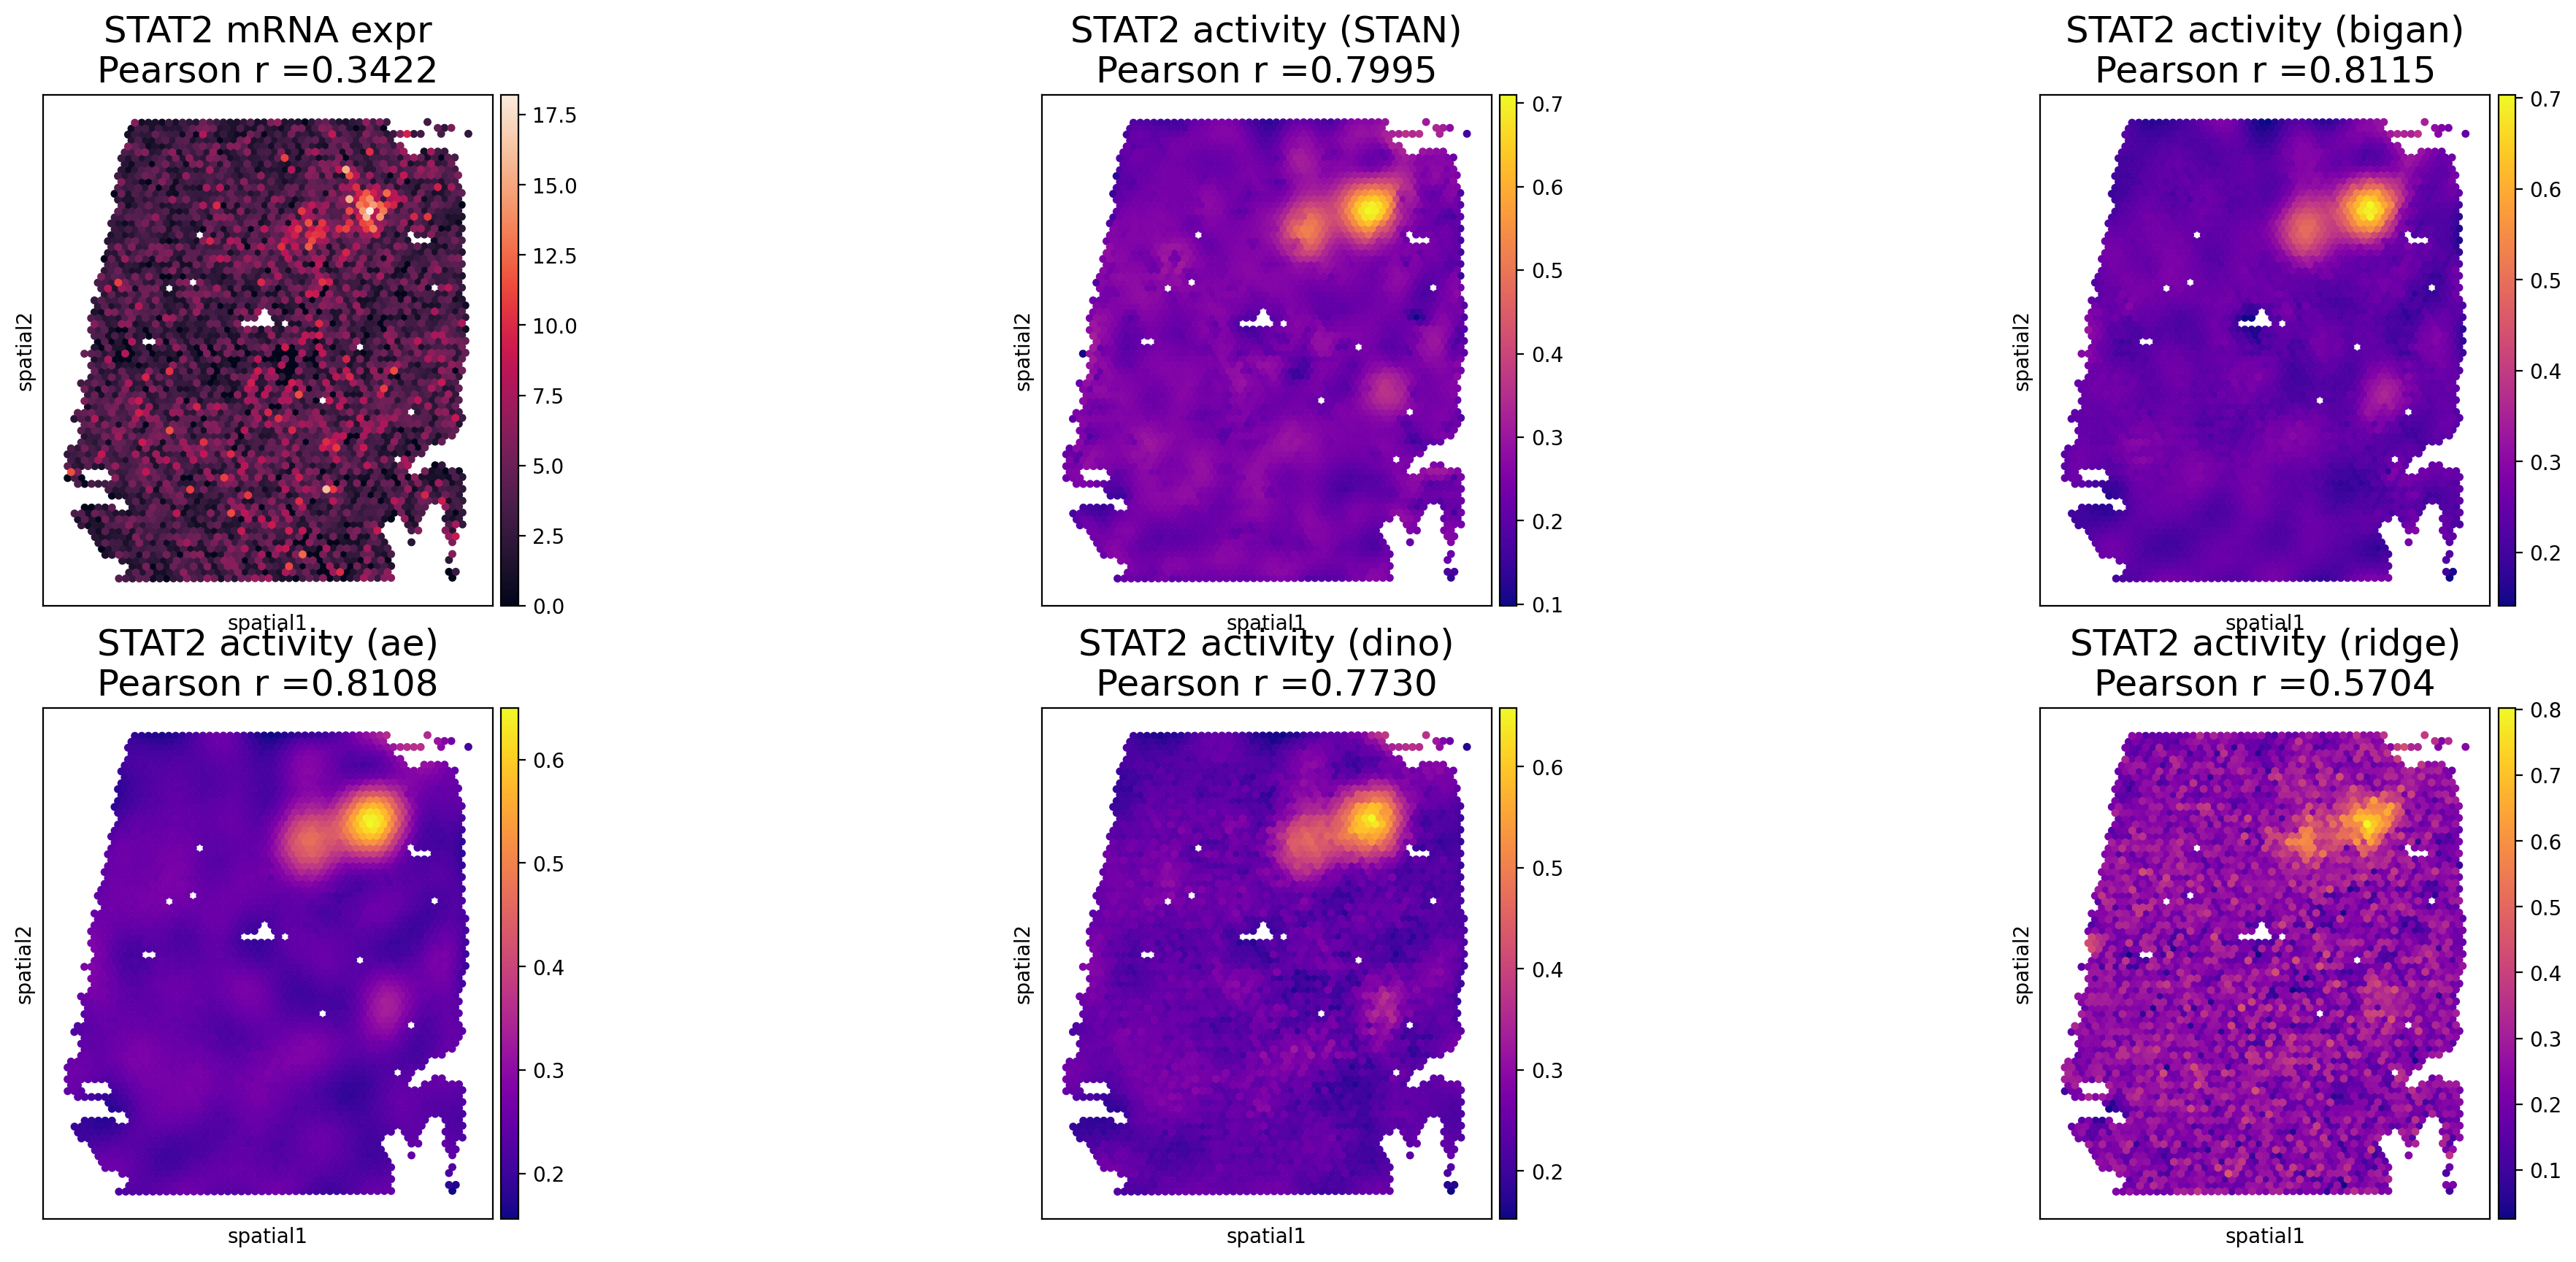

In [15]:
plot_spatial_ct_tf(ct = "B_IFN", tf = "STAT2")

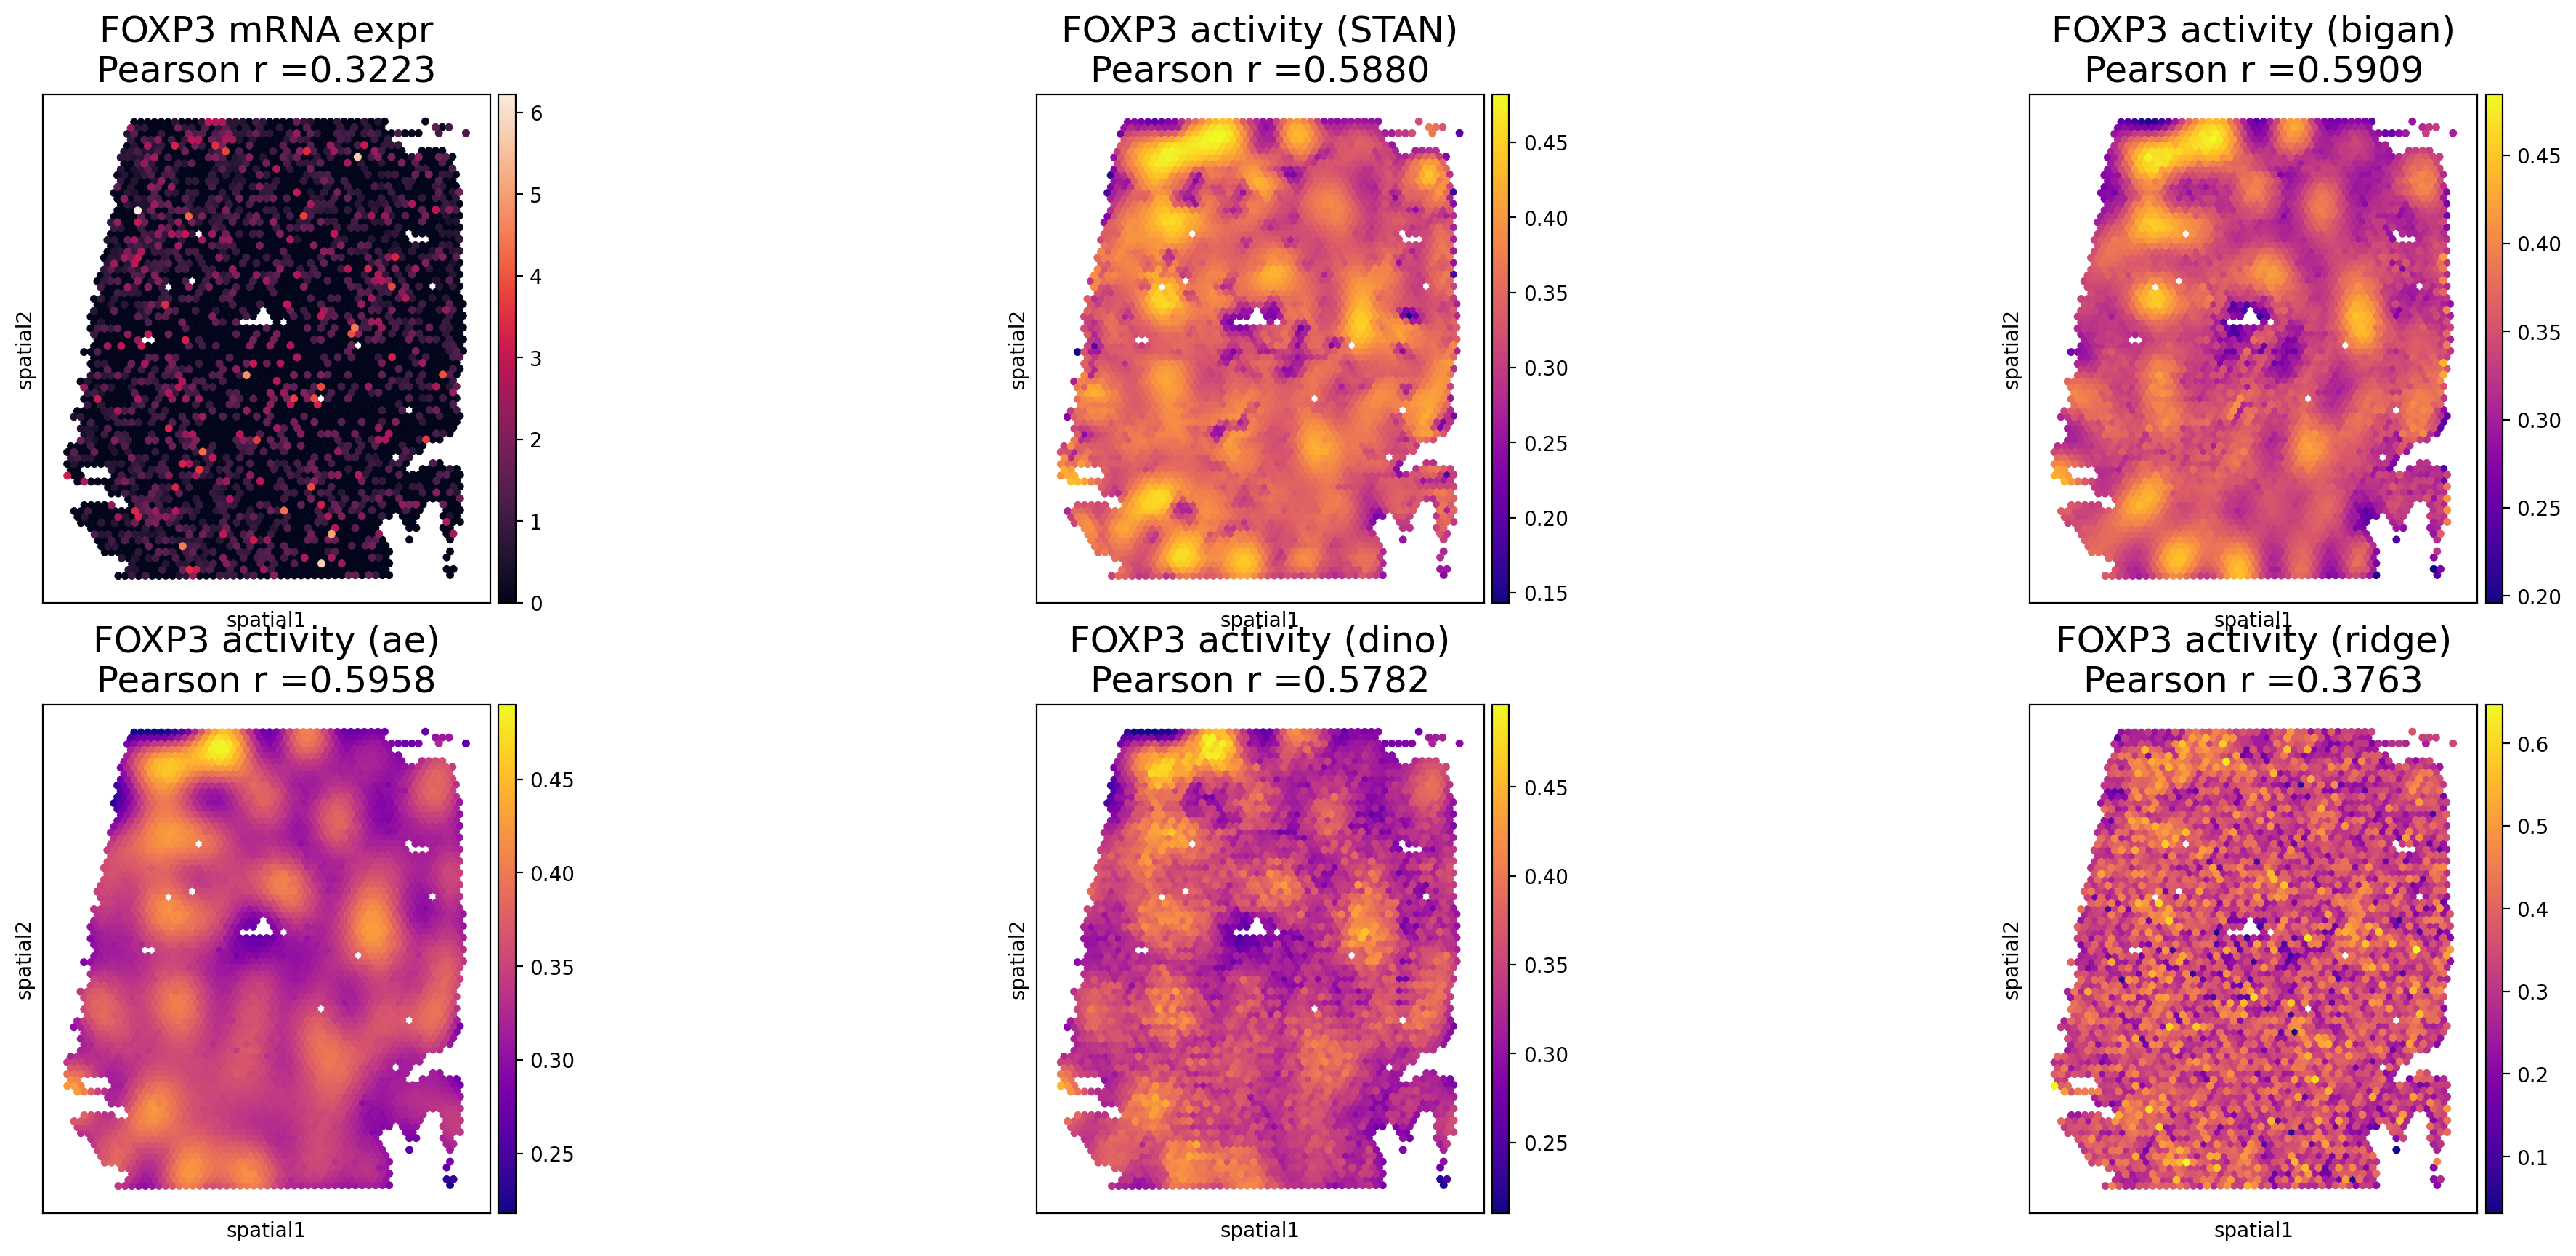

In [16]:
plot_spatial_ct_tf(ct = "T_Treg", tf = "FOXP3")